# Yandex Data Science School
## Linear Regression & Regularization Exercise.


## Outline
In this exercise you will learn the following topics:

1. Refresher on how linear regression is solved in batch and in Gradient Descent 
2. Implementation of Ridge Regression
3. Comparing Ridge, Lasso and vanila Linear Regression on a dataset

# Git Exercise
In this exercise you will also experience working with github.

You might need to install local python enviroment.
Installation Instruction for ex2 - working on a local python environment:
https://docs.google.com/document/d/1G0rBo36ff_9JzKy0EkCalK4m_ThNUuJ2bRz463EHK9I

## please add the github link of your work below:


example: https://github.com/kh2023/y_ml_assignments

## Refresher on Ordinary Least Square (OLS) aka Linear Regeression

### Lecture Note

In Matrix notation, the matrix $X$ is of dimensions $n \times p$ where each row is an example and each column is a feature dimension. 

Similarily, $y$ is of dimension $n \times 1$ and $w$ is of dimensions $p \times 1$.

The model is $\hat{y}=X\cdot w$ where we assume for simplicity that $X$'s first columns equals to 1 (one padding), to account for the bias term.

Our objective is to optimize the loss $L$ defines as resiudal sum of squares (RSS): 

$L_{RSS}=\frac{1}{N}\left\Vert Xw-y \right\Vert^2$ (notice that in matrix notation this means summing over all examples, so $L$ is scalar.)

To find the optimal $w$ one needs to derive the loss with respect to $w$.

$\frac{\partial{L_{RSS}}}{\partial{w}}=\frac{2}{N}X^T(Xw-y)$ (to see why, read about [matrix derivatives](http://www.gatsby.ucl.ac.uk/teaching/courses/sntn/sntn-2017/resources/Matrix_derivatives_cribsheet.pdf) or see class notes )

Thus, the gardient descent solution is $w'=w-\alpha \frac{2}{N}X^T(Xw-y)$.

Solving $\frac{\partial{L_{RSS}}}{\partial{w}}=0$ for $w$ one can also get analytical solution:

$w_{OLS}=(X^TX)^{-1}X^Ty$

The first term, $(X^TX)^{-1}X^T$ is also called the pseudo inverse of $X$.

See [lecture note from Stanford](https://web.stanford.edu/~mrosenfe/soc_meth_proj3/matrix_OLS_NYU_notes.pdf) for more details.


## Exercise 1 - Ordinary Least Square
* Get the boston housing dataset by using the scikit-learn package. hint: [load_boston](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html)

* What is $p$? what is $n$ in the above notation? hint: [shape](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.ndarray.shape.html)

* write a model `OrdinaryLinearRegression` which has a propoery $w$ and 3 methods: `fit`, `predict` and `score` (which returns the MSE on a given sample set). Hint: use [numpy.linalg.pinv](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.linalg.pinv.html) to be more efficient.

* Fit the model. What is the training MSE?

* Plot a scatter plot where on x-axis plot $Y$ and in the y-axis $\hat{Y}_{OLS}$

* Split the data to 75% train and 25% test 20 times. What is the average MSE now for train and test? Hint: use [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) or [ShuffleSplit](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html).

* Use a t-test to proove that the MSE for training is significantly smaller than for testing. What is the p-value? Hint: use [scipy.stats.ttest_rel](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.ttest_rel.html). 

* Write a new class `OrdinaryLinearRegressionGradientDescent` which inherits from `OrdinaryLinearRegression` and solves the problem using gradinet descent. The class should get as a parameter the learning rate and number of iteration. Plot the class convergance. What is the effect of learning rate? How would you find number of iteration automatically? Note: Gradient Descent does not work well when features are not scaled evenly (why?!). Be sure to normalize your features first.

* The following parameters are optional (not mandatory to use):
    * early_stop - True / False boolean to indicate to stop running when loss stops decaying and False to continue.
    * verbose- True/False boolean to turn on / off logging, e.g. print details like iteration number and loss (https://en.wikipedia.org/wiki/Verbose_mode)
    * track_loss - True / False boolean when to save loss results to present later in learning curve graphs

In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import linear_model, metrics, preprocessing
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

**Get the boston housing dataset by using the scikit-learn package. hint: load_boston**

In [2]:
# %% Load Boston Housing Dataset
boston_dataset = load_boston()
boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names) # attributes
prices = pd.DataFrame(boston_dataset.target)  # house prices - labels
X, y = load_boston(return_X_y=True)
#%% Descriptive Statistics
boston.describe()
boston.info()
print(boston_dataset.keys())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
dtypes: float64(13)
memory usage: 51.5 KB
dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])


In [3]:
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


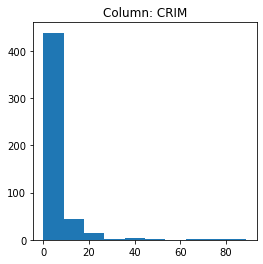

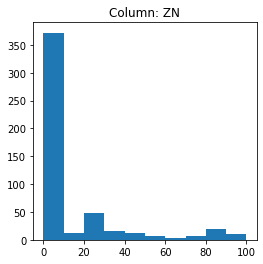

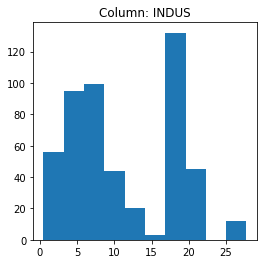

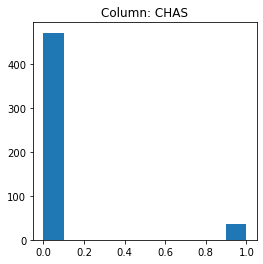

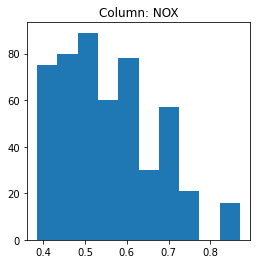

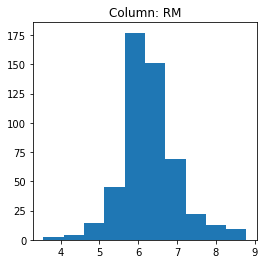

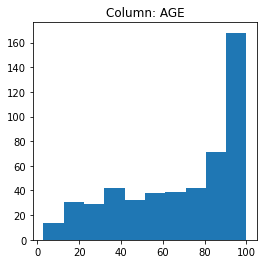

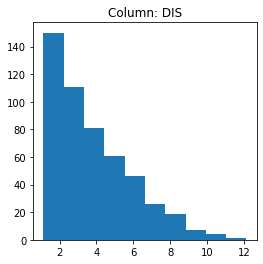

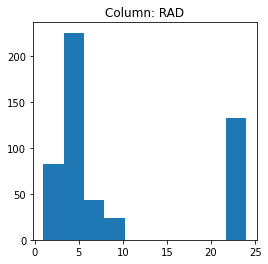

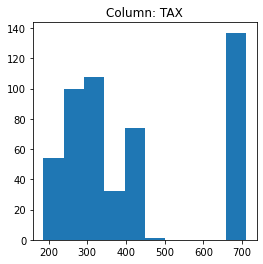

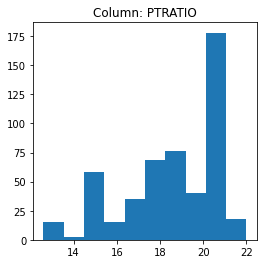

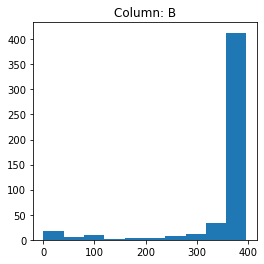

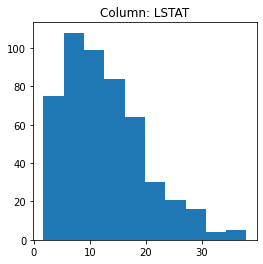

In [4]:
#%% Visualization of Features
for col in boston.columns:
  plt.figure(figsize = (4,4))

  plt.hist(boston[col])
  plt.title(f'Column: {col}')
  plt.show()

**What is  𝑝 ? what is  𝑛  in the above notation? hint: shape**

In [5]:
#%% What is  𝑝 ? what is  𝑛  in the above notation?
print("Number of features (p) is", X.shape[1])
print("Number of samples (n) is ", X.shape[0])

Number of features (p) is 13
Number of samples (n) is  506


**Write a model OrdinaryLinearRegression which has a propoery  𝑤  and 3 methods: fit, predict and score (which returns the MSE on a given sample set). Hint: use numpy.linalg.pinv to be more efficient.**
    ![image.png](attachment:image.png )  
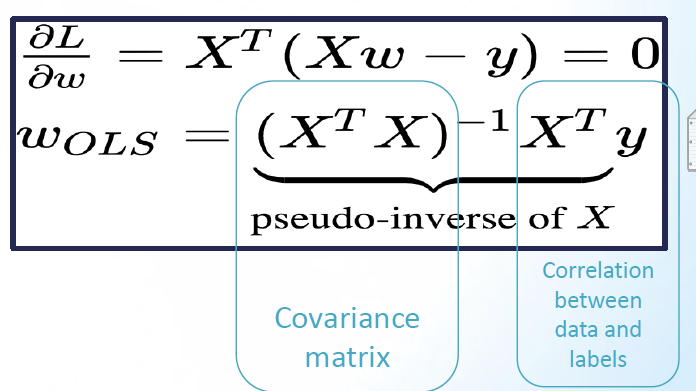

In [6]:
class Ols(object):
  def __init__(self):
    self.w = None
    
  @staticmethod
  def pad(X):
    return np.pad(X, ((0,0), (1,0)), constant_values=1)
  
  def fit(self, X, Y):
    self._fit(X, self._reshape_y(Y)) 

  def predict(self, X):
    return self._predict(X) 

  def score(self, X, Y): 
    return self._score(X, self._reshape_y(Y))   

  def _reshape_y(self, Y):
    # reshaping y to (# samples, 1)
    return Y.reshape(Y.shape[0], 1) 

  def _fit(self, X, Y):
    #remeber pad with 1 before fitting
    padded_x = self.pad(X)
    self.w = np.dot(np.linalg.pinv(padded_x), Y)

    # these are the same:
    # np.linalg.pinv(padded_x)
    # np.dot(np.linalg.inv(np.dot(np.transpose(padded_x), padded_x)), np.transpose(padded_x))

  def _predict(self, X):
    #return xw
    padded_x = self.pad(X)
    return np.dot(padded_x, self.w)

  def _score(self, X, Y):
    #return MSE
    return np.sum(np.square(Y-self.predict(X)))/len(Y)


**Fit the model. What is the training MSE?**

In [7]:
#%% Fit the model. 
model = Ols() 
model.fit(X, y)  
model.predict(X)
model.score(X, y)
print("The training set MSE is:",model.score(X, y) )

The training set MSE is: 21.894831181729202


In [8]:
# Checking these are the same as scikit-learn
lm = LinearRegression()
lm.fit(X, y)
lm.predict(X)
metrics.mean_squared_error(y, lm.predict(X))

21.894831181729202

**Plot a scatter plot where on x-axis plot  𝑌  and in the y-axis  𝑌̂ 𝑂𝐿𝑆**

Text(0, 0.5, 'Y^ OLS')

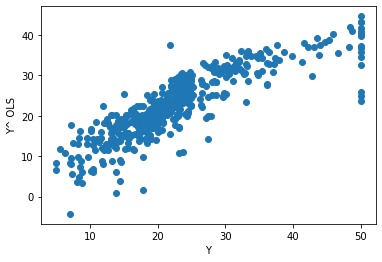

In [9]:
#%% Plot a scatter plot where on x-axis plot  𝑌  and in the y-axis  𝑌̂ 𝑂𝐿𝑆
# Plotting on entire data
plt.scatter(y, model.predict(X))
plt.xlabel('Y')
plt.ylabel('Y^ OLS')

**Split the data to 75% train and 25% test 20 times. What is the average MSE now for train and test? Hint: use train_test_split or ShuffleSplit.**

Using Ols Class:
Average Training MSE: 21.232290872172687
Average Test MSE: 25.671978335557476

 Using Scikit-Learn:
Average Training MSE: 21.232290872172683
Average Test MSE: 25.671978335557462


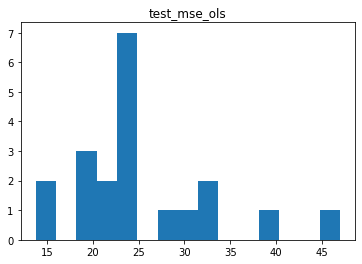

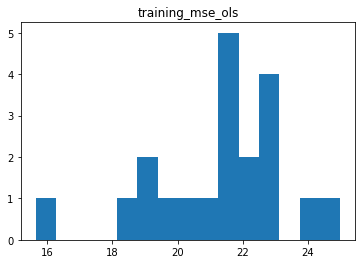

In [10]:
training_mse_scikit_learn = []
test_mse_scikit_learn = []
training_mse_ols = []
test_mse_ols = []

for _ in range(20):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

  # Using Ols class: 
  model = Ols() 
  model.fit(X_train, y_train)  
  training_mse_ols.append(model.score(X_train, y_train))
  test_mse_ols.append(model.score(X_test, y_test))

  # Using scikit-learn: 
  lm = LinearRegression()
  lm.fit(X_train,y_train)
  training_mse_scikit_learn.append(metrics.mean_squared_error(y_train, lm.predict(X_train)))
  test_mse_scikit_learn.append(metrics.mean_squared_error(y_test, lm.predict(X_test)))

print("Using Ols Class:")
print("Average Training MSE:", np.mean(training_mse_ols)) 
print("Average Test MSE:", np.mean(test_mse_ols)) 

print("\n", "Using Scikit-Learn:")
print("Average Training MSE:", np.mean(training_mse_scikit_learn)) 
print("Average Test MSE:", np.mean(test_mse_scikit_learn)) 

#print("training_mse_ols",training_mse_ols)
#print("test_mse_ols",test_mse_ols)
plt.hist(test_mse_ols,bins=15)
plt.title('test_mse_ols')

plt.show()
plt.hist(training_mse_ols,bins=15)
plt.title('training_mse_ols')
plt.show()

**Use a t-test to proove that the MSE for training is significantly smaller than for testing. What is the p-value? Hint: use scipy.stats.ttest_rel.**

In [11]:
print("Test Statistic:", stats.ttest_rel(test_mse_ols,training_mse_ols,alternative="less")[0])
print("P-Value:", stats.ttest_rel(training_mse_ols, test_mse_ols,alternative="less")[1])
if stats.ttest_rel(training_mse_ols, test_mse_ols)[1] < 0.05:
  print("P-Value is smaller than alpha of 0.05; therefore, training MSE is significantly smaller than testing MSE.")
else:
    print("P-value is bigger than alpha = 0.05 therefore we cannot conclude that the training mean is significantly smaller than the test mean")

Test Statistic: 2.0060367020962695
P-Value: 0.029651092003726714
P-value is bigger than alpha = 0.05 therefore we cannot conclude that the training mean is significantly smaller than the test mean


**Write a new class OrdinaryLinearRegressionGradientDescent which inherits from OrdinaryLinearRegression and solves the problem using gradinet descent. The class should get as a parameter the learning rate and number of iteration. Plot the class convergance. What is the effect of learning rate? How would you find number of iteration automatically? Note: Gradient Descent does not work well when features are not scaled evenly (why?!). Be sure to normalize your features first.**
    
**ANSWER:**
The cost function is a perfect circle (in 2D) or hemisphere in (3D). Gradient descent is able to reach the minima (center) easily in a shorter time (https://medium.com/analytics-vidhya/why-gradient-descent-doesnt-converge-with-unscaled-features-8b7ed0c8cab6 ).
Without feature scaling, gradient descent will require a lot more steps to reach the minima. In other words, gradient descent will take a lot of time to converge thus increasing the model training time.
To avoid this, it is always advisable to use feature scaling when working with distance-based cost functions (like MSE, KMeans, SVM etc.)


**Normalizer Class**

In [12]:
#%% Class Normalizer()
class Normalizer():
  def __init__(self):
    self.mean = None
    self.std = None

  def fit(self, X):
    self.mean = np.mean(X, axis=0)  # obtain mean per feature
    self.std = np.std(X, axis=0) # obtain standard deviation per feature

  def predict(self, X):
    # apply normalization using z-score
    return (X-self.mean)/self.std

#%% check against standarscaler (z score)
demo_X_train = np.array([[ 1., -1.,  2.],[ 2.,  0.,  0.], [ 0.,  1., -1.]])
scaler = preprocessing.StandardScaler().fit(demo_X_train)
X_scaled = scaler.transform(demo_X_train)
X_scaled

norm = Normalizer()
norm.fit(demo_X_train)
norm.predict(demo_X_train)

assert (scaler.transform(demo_X_train) == norm.predict(demo_X_train)).all()

**OrdinaryLinearRegressionGradientDescent class **
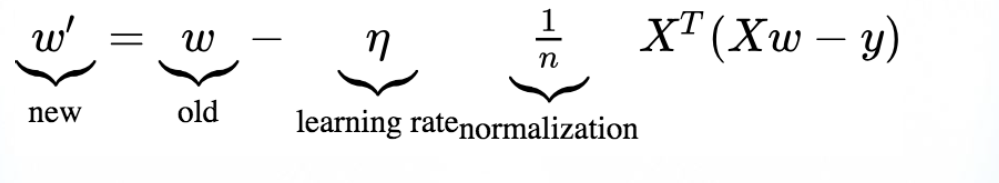

In [13]:
class OlsGd(Ols):
  
  def __init__(self,
      learning_rate=.05,  # learning rate == mu
      num_iteration=1000, 
      normalize=True,
      early_stop=True, # True / False boolean to indicate to stop running when loss stops decaying and False to continue.
      verbose=True,  # True/False boolean to turn on / off logging
      tol=0.0001
    ):
    
    super(OlsGd, self).__init__()
    self.learning_rate = learning_rate
    self.num_iteration = num_iteration
    self.early_stop = early_stop
    self.normalize = normalize
    self.normalizer = Normalizer()    
    self.verbose = verbose
    self.loss_history = []   # initializing a list for loss tracking during convergence
    self._previous_loss = np.inf
    self.tol = tol # tolerance 
    
  def _fit(self, X, Y, reset=True, track_loss=True):  # track_loss - True / False boolean when to save loss results to present later in learning curve graph
    # remeber to normalize the data before starting
    original_X = X
    if self.normalize:
        self.normalizer.fit(X)   
        X = self.normalizer.predict(X)   
    
    padded_X = self.pad(X)
    self.w = np.random.rand(np.size(padded_X, 1), 1) #choose randomly the first array of w's

    for i in range(self.num_iteration):
        self._step(padded_X,Y)
        loss = self.score(original_X, Y)
        if track_loss:
          self.loss_history.append(loss) 
        if self.early_stop and np.abs(self._previous_loss - loss) < self.tol:
          return 
        self._previous_loss = loss

  def _predict(self, X):
    # remeber to normalize the data before starting
    if self.normalize:
        X = self.normalizer.predict(X)  
    return super()._predict(X)
      
  def _step(self, X, Y):
    # use w update for gradient descent
    self.w = self.w - (self.learning_rate * 1.0/len(Y) * self._gradient_loss(X,Y))  # len(Y)==1/n (normalization)

  def _gradient_loss(self, X, Y):
    y_hat = np.dot(X, self.w)
    return np.dot(np.transpose(X), (y_hat-Y))


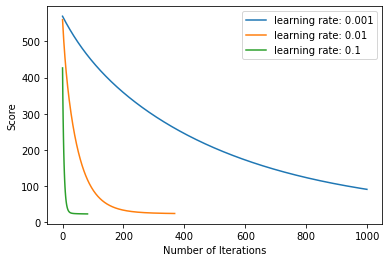

In [14]:
#%% Check scores are similar for Ols and OlsGd
ols = Ols() 
ols.fit(X, y)  
ols.predict(X)
ols.score(X, y)

#%%
olsgd = OlsGd(early_stop=False)
olsgd.fit(X, y)
olsgd.predict(X)
olsgd.score(X, y)

assert abs(ols.score(X, y) - olsgd.score(X, y)) < 0.01

#%% Plot the class convergence
# Plot the loss convergance. for each alpha, learning rate plot the MSE with respect to number of iterations.

# Try different learning rates
learning_rates = [0.001, 0.01, 0.1]
for rate in learning_rates:
  # olsgd_history = OlsGd(learning_rate=rate, tol=0.01, early_stop=False)
  olsgd_history = OlsGd(learning_rate=rate, tol=0.01)
  olsgd_history.fit(X, y)
  plt.plot(olsgd_history.loss_history, label=f'learning rate: {rate}')
plt.xlabel("Number of Iterations")
plt.ylabel("Score") 
plt.legend()


**What is the effect of learning rate?**
The bigger the learning rate the faster the convergence and fewer interations needed

**How would you find number of iteration automatically?**
stop when loss > best_loss - tol (from scikit learn documentation)
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html#sklearn.linear_model.SGDRegressor

## Exercise 2 - Ridge Linear Regression

Recall that ridge regression is identical to OLS but with a L2 penalty over the weights:

$L(y,\hat{y})=\sum_{i=1}^{i=N}{(y^{(i)}-\hat{y}^{(i)})^2} + \lambda \left\Vert w \right\Vert_2^2$

where $y^{(i)}$ is the **true** value and $\hat{y}^{(i)}$ is the **predicted** value of the $i_{th}$ example, and $N$ is the number of examples

* Show, by differentiating the above loss, that the analytical solution is $w_{Ridge}=(X^TX+\lambda I)^{-1}X^Ty$
* Change `OrdinaryLinearRegression` and `OrdinaryLinearRegressionGradientDescent` classes to work also for ridge regression (do not use the random noise analogy but use the analytical derivation). Either add a parameter, or use inheritance.
* **Bonus: Noise as a regularizer**: Show that OLS (ordinary least square), if one adds multiplicative noise to the features the **average** solution for $W$ is equivalent to Ridge regression. In other words, if $X'= X*G$ where $G$ is an uncorrelated noise with variance $\sigma$ and mean 1, then solving for $X'$ with OLS is like solving Ridge for $X$. What is the interpretation? 



**Show, by differentiating the above loss, that the analytical solution is  𝑤𝑅𝑖𝑑𝑔𝑒=(𝑋𝑇𝑋+𝜆𝐼)−1𝑋𝑇𝑦**
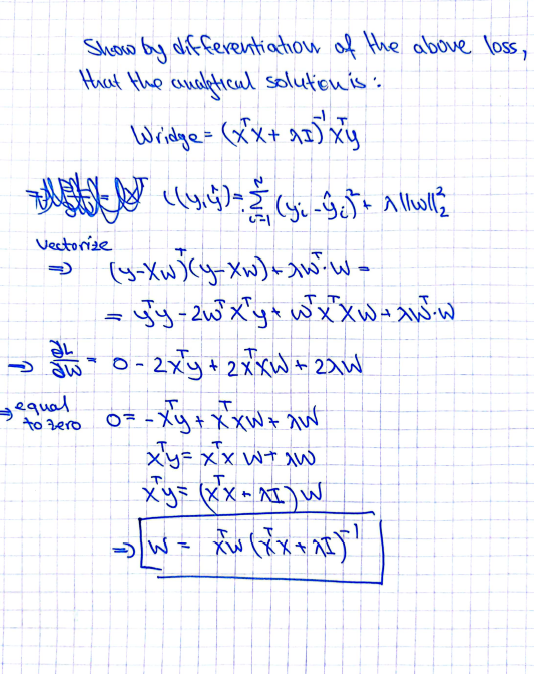

**Change OrdinaryLinearRegression and OrdinaryLinearRegressionGradientDescent classes to work also for ridge regression (do not use the random noise analogy but use the analytical derivation). Either add a parameter, or use inheritance.**

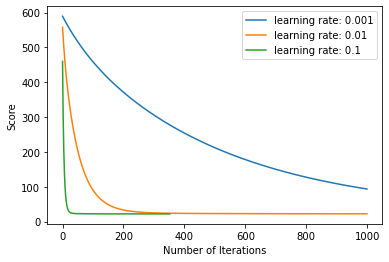

In [15]:
#%%
class RidgeLs(Ols):
  def __init__(self, ridge_lambda, normalize=True, *wargs, **kwargs):
    super().__init__(*wargs, **kwargs)
    self.normalize = normalize
    self.normalizer = Normalizer()
    self.ridge_lambda = ridge_lambda
    
  def _fit(self, X, Y):
    # Closed form of ridge regression
    if self.normalize:
        self.normalizer.fit(X)
        X = self.normalizer.predict(X)
    X = self.pad(X)
    self.w = np.dot(
        np.dot(np.linalg.inv(np.dot(np.transpose(X), X) + np.dot(self.ridge_lambda, np.identity(X.shape[1]))), 
                           np.transpose(X)), Y)

  def _predict(self, X):
    if self.normalize:
        X = self.normalizer.predict(X)  
    return super()._predict(X)

#%%
class RidgeGd(OlsGd):
  def __init__(self, ridge_lambda, *wargs, **kwargs):
    super().__init__(*wargs, **kwargs)
    self.ridge_lambda = ridge_lambda
    
  def _gradient_loss(self, X, Y):
    y_hat = np.dot(X, self.w) 
    return np.dot(np.transpose(X), (y_hat-Y)) + self.ridge_lambda * self.w

#%%
ridgels = RidgeLs(ridge_lambda=1)
ridgels.fit(X, y)
ridgels.score(X, y)

#%%
ridgegd = RidgeGd(ridge_lambda=1)
ridgegd.fit(X, y)
ridgegd.score(X, y)

#%% Scikit-learn Ridge uses a slightly different loss function, but results are very similar when normalized.
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

ridge = make_pipeline(preprocessing.StandardScaler(), linear_model.Ridge(alpha=1))
ridge.fit(X, y)
metrics.mean_squared_error(y, ridge.predict(X))

#%%
learning_rates = [0.001, 0.01, 0.1]
for rate in learning_rates:
  model = RidgeGd(ridge_lambda=1, learning_rate=rate)
  model.fit(X, y)
  plt.plot(model.loss_history, label=f'learning rate: {rate}')
plt.xlabel("Number of Iterations")
plt.ylabel("Score") 
plt.legend()

### Use scikitlearn implementation for OLS, Ridge and Lasso

In [16]:
#%% Use scikit-learn implementation for OLS, Ridge and Lasso
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

model_list = ["OLS", "Ridge", "Lasso"]

for model_name in model_list:
  if model_name == "OLS":
    base_model = linear_model.LinearRegression()
  elif model_name == "Ridge":
    base_model = linear_model.Ridge(alpha=0.1)
  elif model_name == "Lasso":
    base_model = linear_model.Lasso(alpha=0.1)

  model = make_pipeline(preprocessing.StandardScaler(), base_model)
  model.fit(X_train,y_train)
  predictions = model.predict(X_test)

  print(model_name)
  print('MAE:', metrics.mean_absolute_error(y_test, predictions))
  print('MSE:', metrics.mean_squared_error(y_test, predictions))
  print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)), "\n")

# %%

OLS
MAE: 3.16156788218555
MSE: 18.281648267970855
RMSE: 4.275704417750466 

Ridge
MAE: 3.160675195037145
MSE: 18.275055855840737
RMSE: 4.274933432913399 

Lasso
MAE: 3.0593531149303788
MSE: 17.786382493222494
RMSE: 4.217390483844541 



**Bonus: Noise as a regularizer: Show that OLS (ordinary least square), if one adds multiplicative noise to the features the average solution for 𝑊 is equivalent to Ridge regression. In other words, if 𝑋′=𝑋∗𝐺 where 𝐺 is an uncorrelated noise with variance 𝜎 and mean 1, then solving for 𝑋′ with OLS is like solving Ridge for 𝑋. What is the interpretation?**

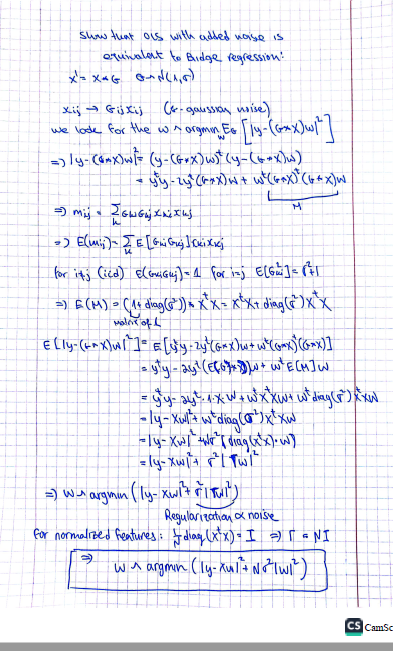